In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option("display.max_columns", None)
%matplotlib inline

DATA = Path("../data")
OUT  = Path("../reports/figures")
OUT.mkdir(parents=True, exist_ok=True)

users = pd.read_csv("../data/users.csv")
transactions = pd.read_csv("../data/transactions.csv")


In [2]:
transactions["Datetime"] = pd.to_datetime(
    transactions["Year"].astype(int).astype(str) + "-" +
    transactions["Month"].astype(int).astype(str).str.zfill(2) + "-" +
    transactions["Day"].astype(int).astype(str).str.zfill(2) + " " +
    transactions["Time"].astype(str),
    format="%Y-%m-%d %H:%M",
    errors="coerce"
)
transactions["hour"] = transactions["Datetime"].dt.hour
transactions["Amount"] = pd.to_numeric(transactions["Amount"], errors="coerce")

users["_income_num"] = (users["Yearly Income - Person"].astype(str)
                        .str.replace("$","", regex=False)
                        .str.replace(",","", regex=False)
                        .astype(float))

In [3]:
df = transactions.merge(users[["User","Gender","_income_num"]], on="User", how="left")
df = df.dropna(subset=["Amount","Datetime"])

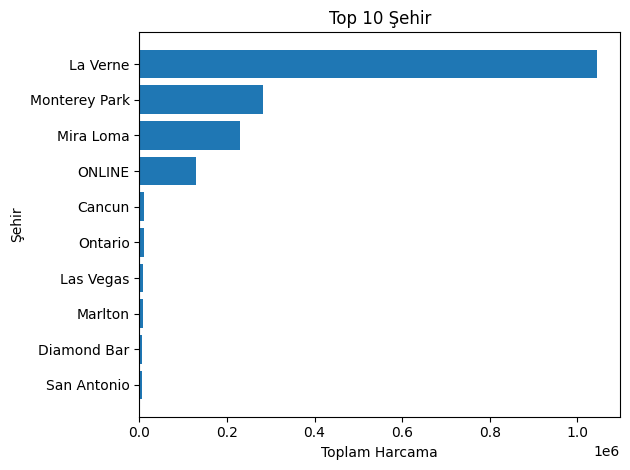

In [4]:
top_cities = (df.groupby("Merchant City")["Amount"]
                .sum().sort_values(ascending=False).head(10))
plt.figure()
plt.barh(top_cities.index[::-1], top_cities.values[::-1])
plt.xlabel("Toplam Harcama"); plt.ylabel("Şehir"); plt.title("Top 10 Şehir")
plt.tight_layout()
plt.savefig(OUT/"top10_cities.png", dpi=160)
plt.show()

In [5]:
#Harcama, diğerlerinin çok üzerinde bir şekilde öne çıkan La Verne'de yoğunlaşmıştır. La Verne ile ikinci büyük şehir Monterey Park arasındaki fark oldukça büyüktür ve bu da oldukça yerel bir harcama modeline işaret etmektedir.

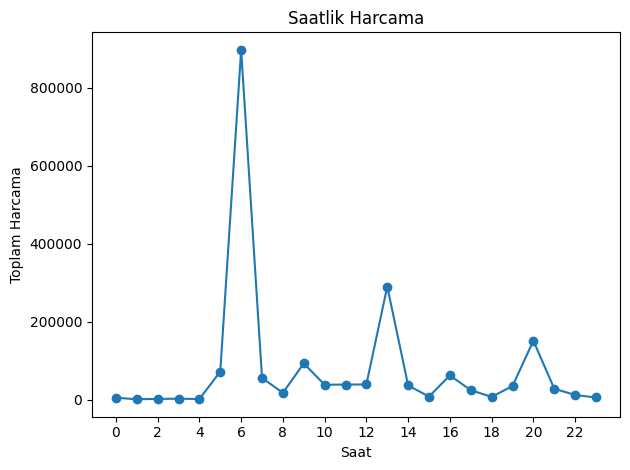

In [6]:
hourly = df.groupby("hour")["Amount"].sum().reindex(range(24), fill_value=0)
plt.figure()
plt.plot(hourly.index, hourly.values, marker="o")
plt.xlabel("Saat"); plt.ylabel("Toplam Harcama"); plt.title("Saatlik Harcama")
plt.xticks(range(0,24,2))
plt.tight_layout()
plt.savefig(OUT/"hourly_spend.png", dpi=160)
plt.show()

In [7]:
#En yüksek harcama hacmi sabah 6 civarında belirgin bir şekilde gerçekleşiyor ve bu da o saatte belirli bir tekrarlayan aktivite veya satın alma davranışına işaret ediyor. Ayrıca, öğle ve akşam alışveriş saatlerine denk gelebilecek 13:00 ve 20:00 saatlerinde de fark edilebilir ancak daha küçük zirveler mevcut.

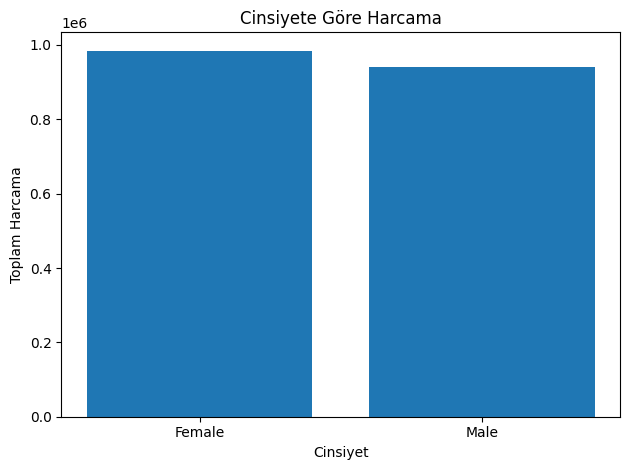

In [8]:
by_gender = df.groupby("Gender")["Amount"].sum().sort_values(ascending=False)
plt.figure()
plt.bar(by_gender.index.astype(str), by_gender.values)
plt.xlabel("Cinsiyet"); plt.ylabel("Toplam Harcama"); plt.title("Cinsiyete Göre Harcama")
plt.tight_layout()
plt.savefig(OUT/"gender_spend.png", dpi=160)
plt.show()

In [9]:
#Kadın müşterilerin toplam harcamaları erkek müşterilere kıyasla biraz daha yüksektir. Aradaki fark çok büyük olmasa da, kadınların genel satışlara biraz daha fazla katkıda bulunabileceğini düşündürecek kadar tutarlıdır.

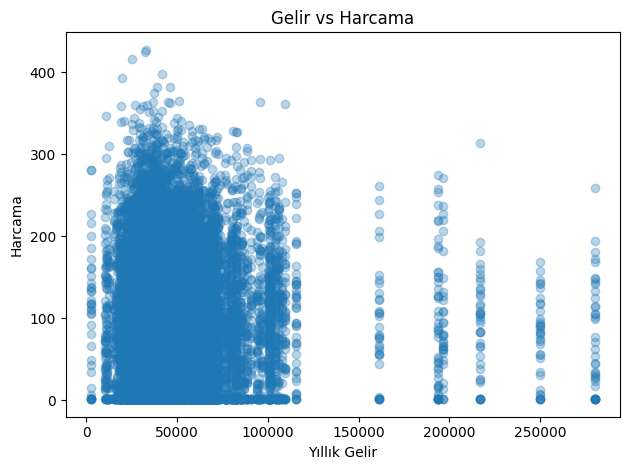

In [10]:
plt.figure()
plt.scatter(df["_income_num"], df["Amount"], alpha=0.3)
plt.xlabel("Yıllık Gelir"); plt.ylabel("Harcama"); plt.title("Gelir vs Harcama")
plt.tight_layout()
plt.savefig(OUT/"income_scatter.png", dpi=160)
plt.show()

In [11]:
#Dağınıklık grafiği, gelir ve harcama arasında güçlü bir doğrusal ilişki göstermemektedir. Farklı gelir seviyelerindeki insanlar, harcama miktarlarında geniş bir yelpazede değişiklik göstermektedir; bu da harcama alışkanlıklarının yalnızca gelirden değil, diğer faktörlerden de etkilendiğini göstermektedir.

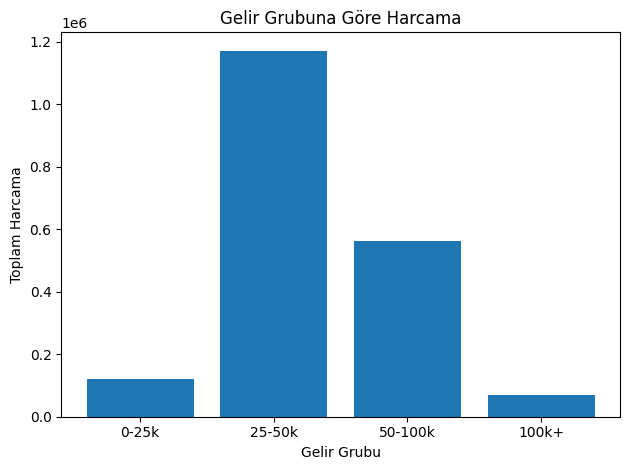

In [12]:
bins   = [0, 25_000, 50_000, 100_000, np.inf]
labels = ["0-25k","25-50k","50-100k","100k+"]
df["income_group"] = pd.cut(df["_income_num"], bins=bins, labels=labels, right=False)
by_group = df.groupby("income_group", observed=False)["Amount"].sum().reindex(labels)
plt.figure()
plt.bar(by_group.index.astype(str), by_group.values)
plt.xlabel("Gelir Grubu"); plt.ylabel("Toplam Harcama"); plt.title("Gelir Grubuna Göre Harcama")
plt.tight_layout()
plt.savefig(OUT/"income_group.png", dpi=160)
plt.show()

In [13]:
#Yıllık 25-50 bin gelir grubu toplam harcamada başı çekerken, onu 50-100 bin gelir grubu takip ediyor. En düşük ve en yüksek gelir grupları genel olarak daha az katkıda bulunuyor; bu da orta gelirli bireylerin bu veri setinde en aktif harcama yapanlar olduğu anlamına gelebilir.

In [14]:
corr = df[["_income_num","Amount"]].corr().iloc[0,1]
summary = {
    "En çok harcama yapılan şehir": top_cities.index[0] if len(top_cities) else None,
    "Tepe saat": int(hourly.idxmax()),
    "Toplam harcamada önde olan cinsiyet": None if by_gender.empty else str(by_gender.index[0]),
    "Gelir-harcama korelasyonu": float(round(corr, 3)),
    "En yüksek harcama yapan gelir grubu": None if by_group.dropna().empty else str(by_group.idxmax()),
    "Şekiller klasörü": str(OUT.resolve())
}
summary

{'En çok harcama yapılan şehir': 'La Verne',
 'Tepe saat': 6,
 'Toplam harcamada önde olan cinsiyet': 'Female',
 'Gelir-harcama korelasyonu': -0.007,
 'En yüksek harcama yapan gelir grubu': '25-50k',
 'Şekiller klasörü': 'C:\\Users\\Efee\\Desktop\\spend-analysis\\patika-spend-analysis\\reports\\figures'}

In [26]:
""" 3. Aşama — Değerlendirme (ChatGPT Katkısı)

**Kullandığım Prompt:**

> "Elimde `Merchant City`, `Amount`, `Transaction Time`, `User`, `Gender`, `Yearly Income - Person` kolonları var.
Şehir bazında harcama ısı haritası ve saatlik yoğunluk için ek hangi grafikler önerirsin? Seaborn kodu ver."

**ChatGPT'den Aldığım Öneri:**
- Şehir bazında harcamaları ısı haritası ile gösterebilirim.  
- Saatlik yoğunluğu KDE (kdeplot) veya histogram ile destekleyebilirim.

**Verilen Kod Örneği:"""

' 3. Aşama — Değerlendirme (ChatGPT Katkısı)\n\n**Kullandığım Prompt:**\n\n> "Elimde `Merchant City`, `Amount`, `Transaction Time`, `User`, `Gender`, `Yearly Income - Person` kolonları var.\nŞehir bazında harcama ısı haritası ve saatlik yoğunluk için ek hangi grafikler önerirsin? Seaborn kodu ver."\n\n**ChatGPT\'den Aldığım Öneri:**\n- Şehir bazında harcamaları ısı haritası ile gösterebilirim.  \n- Saatlik yoğunluğu KDE (kdeplot) veya histogram ile destekleyebilirim.\n\n**Verilen Kod Örneği:'

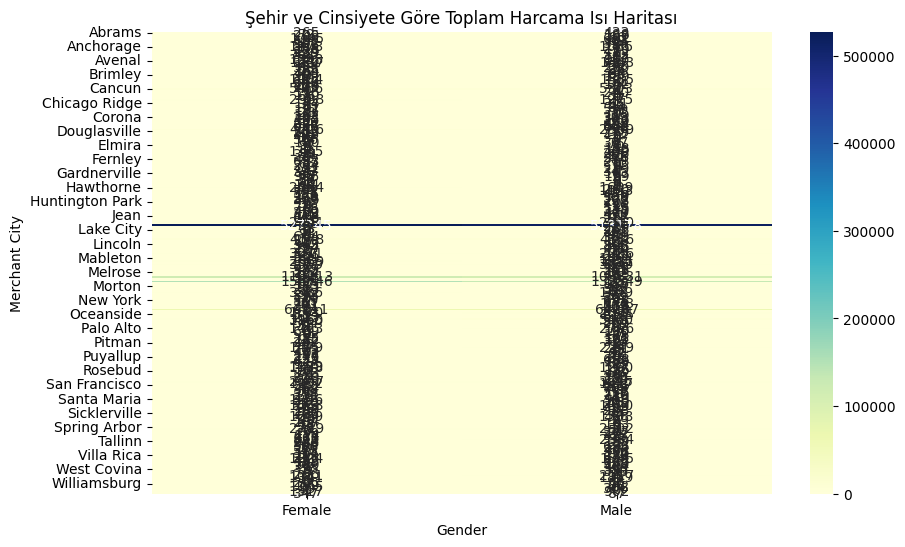

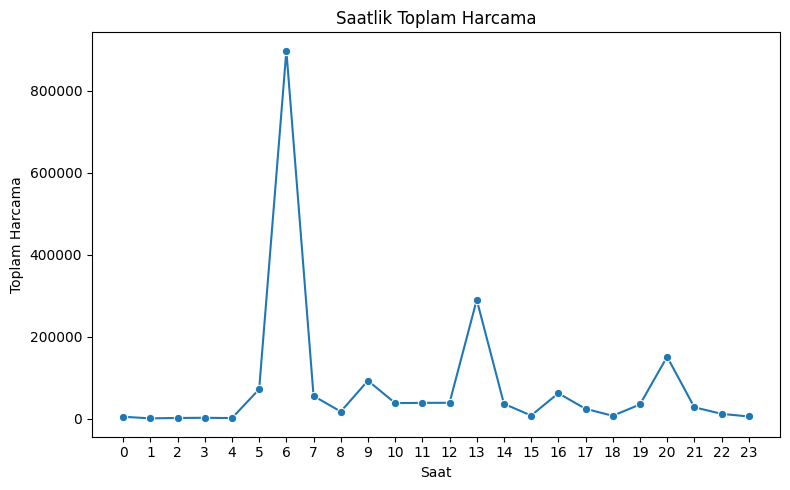

In [24]:
# Şehir bazında harcama ısı haritası
city_pivot = df.pivot_table(values="Amount",
                            index="Merchant City",
                            columns="Gender",
                            aggfunc="sum").fillna(0)

plt.figure(figsize=(10,6))
sns.heatmap(city_pivot, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Şehir ve Cinsiyete Göre Toplam Harcama Isı Haritası")
plt.show()

# Saatlik harcama yoğunluğu (kde)

# tx: transactions, users: users  (önceden okunmuş olmalı)

# Amount → float
transactions["Amount"] = (
    transactions["Amount"].astype(str)
      .str.replace(r"[^0-9.\-]", "", regex=True)
      .replace("", np.nan).astype(float)
)

# Zaman kolonunu bul → Hour üret
time_col = None
for c in ["Transaction Time","Time","Datetime","Timestamp","TransTime"]:
    if c in transactions.columns:
        time_col = c; break
if time_col is None:
    raise KeyError("Zaman kolonu bulunamadı. Kolon adını kontrol et.")

transactions[time_col] = pd.to_datetime(transactions[time_col], errors="coerce")
transactions["Time"] = pd.to_datetime(
    transactions["Time"], 
    format="%Y-%m-%d %H:%M:%S", 
    errors="coerce"
)
transactions["Hour"] = transactions["Time"].dt.hour

# Merge
df = transactions.merge(users, on="User", how="left")

# Güvenlik kontrolleri
assert "Hour" in df.columns, "Hour kolonu yok."
assert "Amount" in df.columns, "Amount kolonu yok."
hourly = (df.groupby("Hour", dropna=True)["Amount"]
            .sum()
            .reindex(range(24), fill_value=0))

plt.figure(figsize=(8,5))
sns.lineplot(x=hourly.index, y=hourly.values, marker="o")
plt.title("Saatlik Toplam Harcama")
plt.xlabel("Saat"); plt.ylabel("Toplam Harcama"); plt.xticks(range(24))
plt.tight_layout(); plt.show()